## Predict Daily Minimum Temperatures using Feedforward NN and RNN

### 1. Import Libraries
***Import libraries needed for data handling, visualization, preprocessing, and building neural networks.***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


### 2. Load Dataset
***Load the daily minimum temperature dataset from the URL, parse dates, and inspect the first few rows.***

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.head()


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### 3. Visualize Data
***Plot the time series to understand temperature trends and seasonality over the years.***

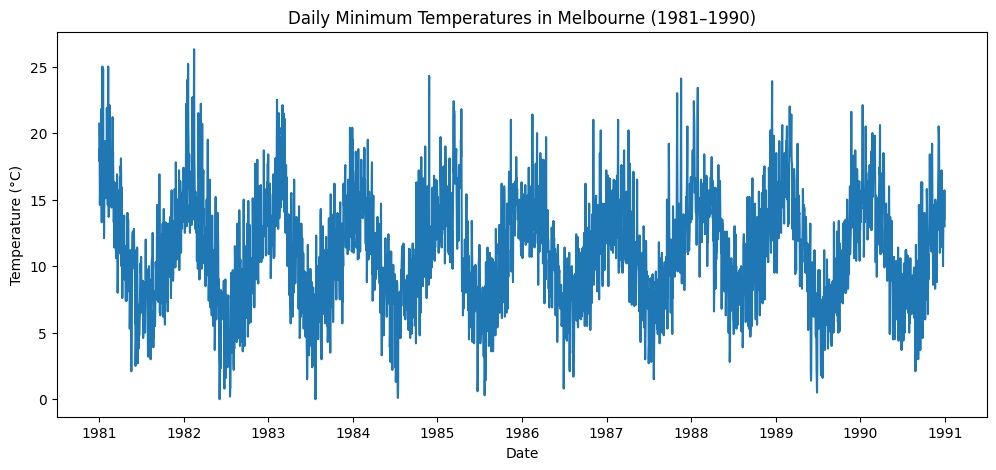

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Temp'])
plt.title('Daily Minimum Temperatures in Melbourne (1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


### 4. Preprocess Data
***Scale the temperatures to [0,1] range and create sequences of past 7 days to predict the next day.***

In [4]:
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(df['Temp'].values.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(temps_scaled, seq_length)


### 5. Train-Test Split
***Split sequences into training and testing sets without shuffling, to respect temporal order.***

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### 6. Feedforward Neural Network
***Build a feedforward NN. Flatten the sequences as it cannot handle temporal dependencies explicitly.***

In [6]:
X_train_ff = X_train.reshape(X_train.shape[0], -1)
X_test_ff = X_test.reshape(X_test.shape[0], -1)

ff_model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_ff.shape[1],)),
    Dense(1)
])
ff_model.compile(optimizer='adam', loss='mse')
ff_model.fit(X_train_ff, y_train, epochs=50, batch_size=16, verbose=0)


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 7. RNN Model
***Build a simple RNN that keeps temporal memory over sequences of 7 days to predict the next day's temperature.***

In [7]:
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 8. Evaluate Models
***Compare predictions of feedforward NN vs RNN and visualize which model captures temporal trends better.***

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


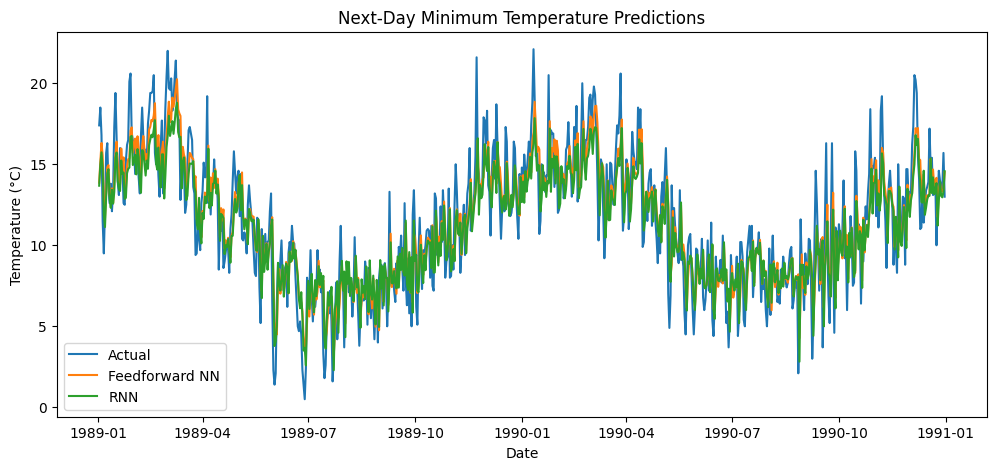

In [8]:
y_pred_ff = ff_model.predict(X_test_ff)
y_pred_rnn = rnn_model.predict(X_test)

# Rescale back to original temperature
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_ff_rescaled = scaler.inverse_transform(y_pred_ff)
y_pred_rnn_rescaled = scaler.inverse_transform(y_pred_rnn)

plt.figure(figsize=(12,5))
plt.plot(df['Date'][-len(y_test_rescaled):], y_test_rescaled, label='Actual')
plt.plot(df['Date'][-len(y_test_rescaled):], y_pred_ff_rescaled, label='Feedforward NN')
plt.plot(df['Date'][-len(y_test_rescaled):], y_pred_rnn_rescaled, label='RNN')
plt.title('Next-Day Minimum Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


### 9. Observations
***Observe that RNN predictions follow trends better because it retains memory of past sequences, unlike feedforward NN which treats each input independently.***

### 10. Evaluate MSE of Both Models
***Calculate Mean Squared Error (MSE) on test data for Feedforward NN and RNN.***

In [9]:
from sklearn.metrics import mean_squared_error

mse_ff = mean_squared_error(y_test_rescaled, y_pred_ff_rescaled)
mse_rnn = mean_squared_error(y_test_rescaled, y_pred_rnn_rescaled)

print(f"Feedforward NN Test MSE: {mse_ff:.3f}")
print(f"RNN Test MSE: {mse_rnn:.3f}")


Feedforward NN Test MSE: 4.957
RNN Test MSE: 5.030


### 11. Calculate RMSE
***Convert MSE to Root Mean Squared Error (RMSE) for better interpretation in °C.***

In [10]:
rmse_ff = np.sqrt(mse_ff)
rmse_rnn = np.sqrt(mse_rnn)

print(f"Feedforward NN RMSE: {rmse_ff:.2f} °C")
print(f"RNN RMSE: {rmse_rnn:.2f} °C")


Feedforward NN RMSE: 2.23 °C
RNN RMSE: 2.24 °C


### 12. Interpretation
***Explain the meaning of MSE and RMSE in practice.***

***Understanding the errors for temperature prediction***

## Key Points:

**1.** **MSE** measures the average squared error between predicted and actual temperatures (°C²).  

**2.** **RMSE** is the square root of MSE, giving the average error in °C.  

**3.** **RMSE ≈ 2.25°C** → On average, predictions are about 2.25°C off from the actual values.  

**4.** Both models perform similarly; **RNN** is slightly better as it captures temporal trends.  

**5.** This level of error is acceptable for general daily forecasting. For **high-precision applications**, lower error may be required.  
